In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## loading the dataset
### as the dataset is in zip file format, we try to unzip the file.

In [17]:
import zipfile

In [19]:
with zipfile.ZipFile('loopr_vit_dse_assignment_data.zip','r') as zip_ref:
    zip_ref.extractall()

FileNotFoundError: [Errno 2] No such file or directory: 'loopr_vit_dse_assignment_data.zip'

### since we are using anaconda, the base environment could not support tensorflow. So we created a new virtual environment to build and run our model

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model

In [13]:
import glob
path = '../input/chess-pieces-detection-images-dataset'
path_img = list(glob.glob(path+'/**/*.jpg'))
# we use glob to return all file paths that match the specified pattern, for all the files



### creating labels and putting our dataset into data frames

In [15]:
#df = pd.read_csv(r"C:\Users\lenovo\loopr_ai_assignment\dataset")

In [16]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))


In [29]:
file_path = pd.Series(path_img, name='File_Path',dtype='float64').astype(str)

In [31]:
labels = pd.Series(labels, name='Labels',dtype='float64')

In [32]:
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels


### To perform EDA and Visualization

NameError: name 'data' is not defined

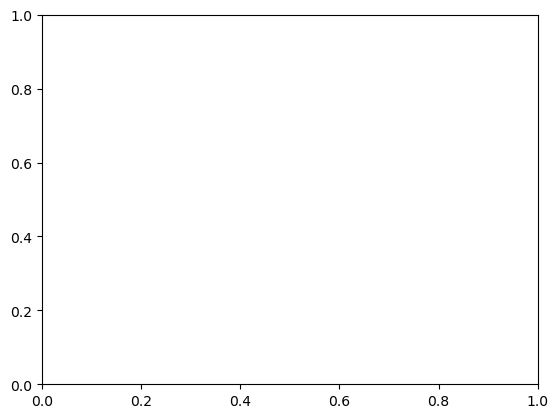

In [27]:
import streamlit as st

fig, ax = plt.subplots()
ax.barh(data.file_path,data.label)
plt.xticks(rotation='vertical')


st.title('EDA')

st.pyplot(fig)

In [25]:
#visualization

counts = data.Labels.value_counts()
sns.distplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=15);

NameError: name 'data' is not defined

In [29]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def func(pre,name_model,size):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    
    pre_model = name_model(input_shape=(size,size, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_gen,validation_data=valid_gen,epochs=100,callbacks=my_callbacks,verbose=0);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
result_InceptionV3 = func(preprocess_input,InceptionV3,100)

## ResNet 50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet50 = func(preprocess_input,ResNet50,100)

## ResNet 152

In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet152 = func(preprocess_input,ResNet152,100)

## ResNet 101

In [ ]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
result_ResNet101V2 = func(preprocess_input,ResNet101V2,100)

## DenseNet 

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = func(preprocess_input,DenseNet201,100)

## Conclusion

In [ ]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20);